In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import xlrd
import os
import fiona
from statistics import mean, median
import string
import math
import re

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

pd.set_option('display.max_rows', 200)

# VEST NE 2016

## VEST Documentation

### Sources

Election results from OpenElections, gathered from county elections officials.

### Shapefiles

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. 

Adams, Antelope, Box Butte, Buffalo, Burt, Butler, Cass, Chase, Cherry, Cuming, Custer, Dakota, Dawes, Dawson, Deuel, Dodge, Douglas, Garfield, Hamilton, Harlan, Holt, Kearney, Keith, Keya Paha, Kimball, Lancaster, Lincoln, Madison, Merrick, Morrill, Nemaha, Nuckolls, Otoe, Perkins, Phelps, Platte, Red Willow, Richardson, Saline, Sarpy, Scotts Bluff, Seward, Stanton, Thayer, Valley, and Washington either used a replacement shapefile or, more often, required tweaks based on PDF maps from county election officials or geocoded voter registration files.

Some counties reported one or more classes of votes at the county level. These were distributed by candidate based on the precinct-level reported vote.

Write-in votes were inconsistently provided by the counties, so they were excluded. Unofficial precinct results from NE Secretary of State used as a cross-reference in places.

### Races

G16PRERTRU - Donald Trump (Republican Party)<br>
G16PREDCLI - Hillary Clinton (Democratic Party)<br>
G16PRELJOH - Gary Johnson (Libertarian Party)<br>
G16PREGSTE - Jill Stein (Green Party)<br>

## Load in VEST file

In [2]:
vest_ne_2016 = gp.read_file('./raw-from-source/VEST/ne_2016/ne_2016.shp')

<AxesSubplot:>

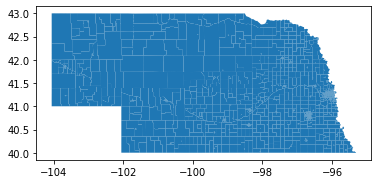

In [3]:
vest_ne_2016.plot()

## Build table of precinct-level election results from NE SOS Spreadsheets

The 2016 election results provided by NE SOS are designed for human legibility, not algorithmic use. They need to be cleaned, transformed, and reformatted in order for them to be usable here; this section outlines that process.

Notes for parsing NE SOS's Excel files:
- Each county's excel document contains many races separated by whitespace rows.
- Ignore column B; it only contains the name of the county (which we have from the filename). In the vote tables, it's just an unnecessary blank column.
- When the county spreadsheets are loaded in as dataframes, their default column headings are not descriptive. To make this easier to follow, we assign alphabetical column names that align with Excel's typical column naming conventions (Column 1 = "A", Column 2 = "B", etc.)
- Harlan County's results are distributed as a PDF, and not as a spreadsheet. To make these results machine readable, we digitized them to a file called `harlan-16-results-digitized.csv`, and are distributing it along with the PDF that NE SOS sent us.

In [30]:
# point to directory that contains NS SOS .xls files
ER_INPUT_DIR = './raw-from-source/Election_Results/'

# If this is true, NE SOS spreadsheets will be read, and their containing data will be used to 
# create a single CSV file that contains all statewide precinct data.
SHOULD_PROCESS_INPUT_DATA = False

In [5]:
# Returns the letter at position 'num' in the English alphabet. A=1, B=2, ..., Z=26. 
def num_to_letter(num):
    return chr(ord('@') + num)

# Returns a cleaned NE 2016 county spreadsheet as a dataframe. 
# This function renames each column from its default value of "Unnamed: i" to the i+1th letter in the English alphabet. 
# Column B is removed because it contains no meaningful information, and every blank row is removed as well. 
#
# Each of these sheets contains the results of every race that happened in 2018 within the county. 
def load_county_excel_sheet(path_to_file):
    county_xls = pd.read_excel(path_to_file, skiprows=1)
    cols = list(map(lambda e: num_to_letter(e), range(1, len(county_xls.columns)+1)))
    county_xls.columns = cols
    cols.remove('B')
    county_xls = county_xls[cols]
    county_xls = county_xls.dropna(how='all')
    county_xls = county_xls.reset_index(drop=True)
    return county_xls.copy(deep=True)

In order to separate the tables for different candidates/races in each county's spreadsheet, we need to detect where each table starts and ends. Each table starts with a row that contains something close to an office/race label (e.g., "For President and Vice President of the United States"), and each table ends with a row that contains the total number of votes for each office. Throughout this section, we'll refer to the rows that contain office/race values as "office rows", and the row w/ vote totals as "total rows". 

Examples of these key rows are highlighted in yellow in the diagram below.

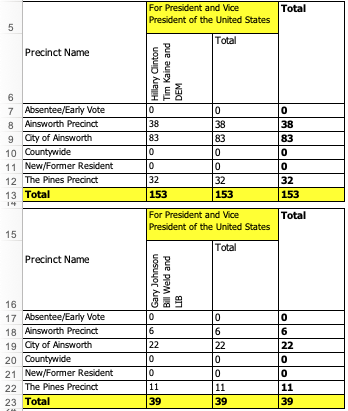

These rows have distinguishing features that we can search for to find their locations (i.e., row numbers) in each county's spreadsheet:

`office_rows = county_xls[(county_xls['A'] == 'Precinct Name') & (~county_xls['C'].isnull())]`<br>
`total_rows = county_xls[county_xls['A'] == 'Total']`

In the code below, we use these key rows to detect the height of each table.

In [6]:
# Attempts to find the boundaries of each subtable in a county spreadsheet by looking for rows containing
# office/race information, and by looking for "total" rows. 
#
# Returns a list of tuples (s, t), one per subtable detected in county_xls. 
# s = the starting row # of the subtable
# t = the ending row # of the subtable. 
#
# This function expects that the `county_xls` dataframe has been cleaned and prepared in the 
# manner performed by the load_county_excel_sheet() function. 
#
# Raises a ValueException if there's a problem detecting boundaries. 
def detect_table_boundaries(county_xls):
    office_indices = list(county_xls[(county_xls['A'] == 'Precinct Name') & (~county_xls['C'].isnull())].index)
    total_indices = list(county_xls[county_xls['A'] == 'Total'].index)
    table_boundary_pairs = list(zip(office_indices, total_indices))
    
    # check that there are an equal number of "office" rows and total rows. 
    # If not, file is malformed and data must be extracted manually.
    if len(office_indices) != len(total_indices):
        raise ValueException('Number of office rows {0} != number of total rows {1}.'.format(len(office_indices), len(total_indices)))

    # check that there is no distance between each table. Since we've removed whitespace, distance likely means that
    # our table separation routine failed and the races will have to be separated manually.  
    for idx, pair in enumerate(table_boundary_pairs):
        if idx != len(table_boundary_pairs)-1:
            pair_next = table_boundary_pairs[idx+1]
            if pair_next[0] - pair[1] != 1:
                raise ValueException('Table boundary error detected. "Total" at row # {0}, Next "office" row at {1}'.format(pair[1], pair_next[0]))
    
    return table_boundary_pairs

The row below each "office row" is a row that we'll refer to as a "candidate row". It contains the name of the candidate whose votes are described in the subtable that follows. 

This code extracts the candidate's name from a "candidate row". It removes unnecessary party affiliations, formatting characters, and gratuitous whitespace from each cell, and it returns the candidate's name as a simple string.

In [7]:
# Extracts the name of a candidate from a sub-table in a 2016 county excel spreadsheet.
def extract_candidate_from_row(r):
    # eliminate NaN values and all "total" rows. All that will remain are the candidate's name. 
    l = list(filter(lambda e: not pd.isna(e), r))
    raw_candidates = list(filter(lambda e: e != 'Total', l))
    
    # partisan candidate names and their parties are delimited by newlines. 
    candidate_names = list(map(lambda e: e.split('\n')[0].strip(), raw_candidates))
    return candidate_names[0]

We only need to keep precinct data for the four presidential candidates. The function below uses these constants to detect presidential races, and to translate each of the candidate's names to their VEST identifier. 

In [8]:
PRES_OFFICE_LABEL = 'For President and Vice President of the United States'

candidate_labels_to_vest = {
    'Donald J. Trump Michael R. Pence and': 'G16PRERTRU',
    'Hillary Clinton Tim Kaine and': 'G16PREDCLI',
    'Gary Johnson Bill Weld and': 'G16PRELJOH',
    'Jill Stein Ajamu Baraka and': 'G16PREGSTE'
}

In [9]:
# Extracts the presidential race tables from a county spreadsheet. 
# Returns a dictionary that maps each candidate's VEST identifier to its race table.
def extract_races_from_excel(county_xls, county_name):
    race_tables = {}
    # if we can detect table boundaries, we can extract the presidential data from this sheet.
    try: 
        tb_pairs = detect_table_boundaries(county_xls)
        for office_idx, end_idx in tb_pairs:
            office_val = county_xls.at[office_idx, 'C'].strip()
            # if this row is a presidential election table, proceed to extracting the precinct data from it. 
            if office_val == PRES_OFFICE_LABEL:
                # extract the candidate's name and retrieve their VEST column identifier. 
                candidate_label = extract_candidate_from_row(county_xls.loc[office_idx+1])
                vest_id = candidate_labels_to_vest[candidate_label]
                # extract the vote data from this subtable. 
                # Column 'A' contains precinct names, column 'C' contains number of votes this candidate received in each precinct.
                race_table = county_xls[['A', 'C']].loc[(office_idx+2):(end_idx-1)].copy(deep=True)
                race_table.columns = ['Precinct', vest_id]
                race_tables[vest_id] = race_table  
    except ValueError as e:
        print('Error when extracting races from {0} from county: {1}'.format(county_name, e))
    return race_tables
                

By combining all of the functions above, we can separate the presidential subtables from each county's spreadsheet, and ignore everything else we don't care about. 

This block creates a single file called `2016-statewide-results-by-pcnt.csv` which contains the precinct-level results for each of the four presidential candidates statewide. We'll use this file for the rest of the notebook, because it's much simpler to reference than a collection of spreadsheets. 

To avoid unnecessarily processing the NE SOS spreadsheets every time this notebook is reloaded, the block below will not run unless the `SHOULD_PROCESS_INPUT_DATA` (defined above) is set to `True`. Since a copy of `2016-statewide-results-by-pcnt.csv` is distributed with this notebook's source files, you'll only need to re-create it here if you want to trace this notebook's complete execution pipeline. 

In [10]:
# `2016-statewide-results-by-pcnt.csv` will be saved in this directory.
OUTPUT_DIR = './raw-from-source/Election_Results/'

input_files = os.listdir(ER_INPUT_DIR)
county_tables = {}

if SHOULD_PROCESS_INPUT_DATA:
    # extract results from each county spreadsheet
    for fn in list(filter(lambda e: e.endswith('.xls'), input_files)):
        county_name = fn.split('.xls')[0]
        input_fp = os.path.join(ER_INPUT_DIR, fn)

        # load and clean input sheet. Extract the presidential data tables from it.
        county_xls = load_county_excel_sheet(input_fp)
        race_tables = extract_races_from_excel(county_xls, county_name)

        # combine the separate tables for each presidential candidate into a single table. 
        # Use Trump's table (chosen arbitrarily) as the base table for joining. 
        county_df = race_tables['G16PRERTRU']
        other_candidate_ids = list(candidate_labels_to_vest.values())
        other_candidate_ids.remove('G16PRERTRU')
        for vest_id in other_candidate_ids:
            next_df = race_tables[vest_id]
            county_df = county_df.merge(next_df, how='outer', on='Precinct').copy(deep=True)

        # Add an explicit county column so we can create a single table w/ all precinct results.
        county_df['County'] = county_name
        county_tables[county_name] = county_df

    # build a statewide file that contains every county's presidential results by precinct
    statewide_df = pd.concat(county_tables.values(), axis=0)
    cols = ['County', 'Precinct'] + list(candidate_labels_to_vest.values())
    statewide_df = statewide_df[cols]

    # check for NaNs in the final table which would indicate a problem during joining
    for c in cols:
        s = statewide_df[c]
        if pd.isnull(s).any():
            print('NAN found in column {0}!'.format(c))

    # add in our digitized results for Harlan County, which should be in the same directory as the spreadsheets.
    harlan_df = pd.read_csv(os.path.join(ER_INPUT_DIR, 'harlan-16-results-digitized.csv'))
    statewide_df = pd.concat([statewide_df, harlan_df], axis=0)
    statewide_df = statewide_df.sort_values(['County', 'Precinct', 'G16PRERTRU', 'G16PREDCLI'])

    # write the full table if it looks good. 
    target_filename = '2016-statewide-results-by-pcnt.csv'
    output_fp = os.path.join(OUTPUT_DIR, target_filename)
    statewide_df.to_csv(output_fp, index=False)  

### Load in Raw Election Results

This is just the file we created in the "Build table of precinct-level election results from NE SOS Spreadsheets" section above. 

In [11]:
er_2016_df = pd.read_csv('./raw-from-source/Election_Results/2016-statewide-results-by-pcnt.csv')
er_2016_df['Precinct'] = er_2016_df['Precinct'].apply(lambda e: str(e).strip())

### Validate statewide totals

In [12]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [13]:
races = list(candidate_labels_to_vest.values())
statewide_totals_check(vest_ne_2016, er_2016_df, races)

***Statewide Totals Check***
G16PRERTRU is equal 	VEST / RDH: 495961
G16PREDCLI is equal 	VEST / RDH: 284494
G16PRELJOH is equal 	VEST / RDH: 38946
G16PREGSTE is equal 	VEST / RDH: 8775


### Validate county totals

In [14]:
fips_df = pd.read_csv('./raw-from-source/FIPS/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_dict = dict(zip(fl['County Name'], fl['FIPS County']))
er_2016_df['FIPS'] = er_2016_df['County'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()
er_2016_df = er_2016_df[(['FIPS', 'Precinct'] + races)]
er_2016_df = er_2016_df.rename(columns={'FIPS':'COUNTY', 'Precinct': 'NAME'})
ne_2016_df = er_2016_df[(['COUNTY', 'NAME'] + races)]

In [15]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [16]:
# VEST's county and precinct name columns are "COUNTYFP" and "NAMELSAD", respectively. 
# Temporarily change the columns of the source data table to match these so we can compare county totals. 
ne_2016_4cv = ne_2016_df.copy(deep=True)
ne_2016_4cv = ne_2016_4cv.rename(columns={'COUNTY': 'COUNTYFP', 'NAME': 'NAMELSAD'})
county_totals_check(vest_ne_2016, ne_2016_4cv, races, 'COUNTYFP', full_print=False)

***Countywide Totals Check***

G16PRERTRU is equal across all counties
G16PREDCLI is equal across all counties
G16PRELJOH is equal across all counties
G16PREGSTE is equal across all counties


## Absentee Allocation

Do basic standardization of precinct names before allocating absentee votes. 

In [17]:
# transform the precinct name column in both data sets to all uppercase
ne_2016_df['NAME'] = ne_2016_df['NAME'].apply(lambda e: e.upper())
vest_ne_2016['NAMELSAD'] = vest_ne_2016['NAMELSAD'].apply(lambda e: e.upper())

Remove precincts from the source data set that contain votes that need to be re-allocated. In this data set, absentee votes are labeled in one of four ways:

- `ABSENTEE`
- `ABSENTEE/EARLY VOTE`
- `COUNTYWIDE`
- `NEW/FORMER RESIDENT`

In [18]:
to_allocate_df = ne_2016_df.loc[ne_2016_df['NAME'].isin(['ABSENTEE/EARLY VOTE', 'COUNTYWIDE', 'NEW/FORMER RESIDENT', 'ABSENTEE'])]
ne_2016_df = ne_2016_df.loc[~ne_2016_df['NAME'].isin(['ABSENTEE/EARLY VOTE', 'COUNTYWIDE', 'NEW/FORMER RESIDENT', 'ABSENTEE'])]

Some counties have multiple groups of votes that need to be allocated (e.g., X votes labeled as `ABSENTEE/EARLY VOTE`, Y votes labeled as `COUNTYWIDE`, and Z votes labeled as `NEW/FORMER RESIDENT`). 

To make the allocation simpler, we'll combine each of the absentee votes within a county together under a single `"ABSENTEE"` label.

In [19]:
vote_cols = list(candidate_labels_to_vest.values())
to_allocate_df = to_allocate_df.groupby('COUNTY').sum(vote_cols).copy(deep=True)
to_allocate_df['NAME'] = 'ABSENTEE'
to_allocate_df = to_allocate_df[['NAME'] + vote_cols]
to_allocate_df = to_allocate_df.reset_index()

In [20]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

Allocate the collected absentee votes across each precinct statewide.

In [21]:
ne_2016_df = allocate_absentee(ne_2016_df, to_allocate_df, vote_cols, 'COUNTY')

### Merge Source Results onto VEST

Assign unique ID to each row in both data sets by joining the county and precinct name together. Then we'll attempt to join the source results and the VEST results using this identifier.

In [22]:
vest_ne_2016['unique_ID'] = vest_ne_2016['COUNTYFP'] + '-' + vest_ne_2016['NAMELSAD']
ne_2016_df['unique_ID'] = ne_2016_df['COUNTY'] + '-' + ne_2016_df['NAME']

In [23]:
merge_1_df = pd.merge(vest_ne_2016, ne_2016_df, how='outer', on='unique_ID', indicator=True, validate='1:1').copy(deep=True)
print(merge_1_df['_merge'].value_counts())

right_only    1076
left_only     1065
both           310
Name: _merge, dtype: int64


Apply the source to VEST precinct name mapping, then try to merge again.

In [24]:
nan = np.nan
s2v = {'001-1-A': '001-1A', '001-1-B': '001-1B', '001-1-C': '001-1C', '001-2-A': '001-2A', '001-2-B': '001-2B', '001-2-C': '001-2C', '001-2-D': '001-2D', '001-2-E': '001-2E', '001-3-A': '001-3A', '001-3-B': '001-3B', '001-3-C': '001-3C', '001-3-D': '001-3D', '001-3-E': '001-3E', '001-4-A': '001-4A', '001-4-B': '001-4B', '001-4-C': '001-4C', '001-4-D': '001-4D', '001-4-E': '001-4E', '001-JUNIATA': '001-JUNIATA PRECINCT', '001-WESTBLUE/HIGHLAND': '001-HIGHLAND_WEST_BLUE', '003-NELIGH 1ST WARD': '003-NELIGH CITY 1ST WARD', '003-NELIGH 2ND WARD': '003-NELIGH CITY 2ND WARD', '005-ARTHUR': '005-ARTHUR PRECINCT', '007-LONG SPRINGS': '007-LONG SPRINGS PRECINCT', '009-VILLAGE OF DUNNING': '009-BLAINE PRECINCT', '011-BEAVER': '011-BEAVER PRECINCT', '011-BOONE': '011-BOONE PRECINCT', '011-CEDAR': '011-CEDER PRECINCT', '011-DUBLIN-BONANZA': '011-DUBLIN-BONANZA PRECINCT', '011-ELKHORN RURAL PPD #1': nan, '011-ELKHORN RURAN PPD #3': nan, '011-NORTH BRANCH-SHELL CREEK': '011-NORTH BRANCH-SHELL CREEK PRECINCT', '011-NORTH MANCHESTER': '011-NORTH MANCHESTER PRECINCT', '011-OAKLAND': '011-OAKLAND PRECINCT', '011-SOUTHEAST MANCHESTER': '011-SOUTHEAST MANCHESTER PRECINCT', '011-SOUTHWEST MANCHESTER': '011-SOUTHWEST MANCHESTER PRECINCT', '013-PRECINCT 1': '013-VOTING PRECINCT 1', '013-PRECINCT 11': '013-VOTING PRECINCT 11', '013-PRECINCT 12': '013-VOTING PRECINCT 12', '013-PRECINCT 15': '013-VOTING PRECINCT 15', '013-PRECINCT 2': '013-VOTING PRECINCT 2', '013-PRECINCT 3': '013-VOTING PRECINCT 3', '013-PRECINCT 4': '013-VOTING PRECINCT 4', '013-PRECINCT 5': '013-VOTING PRECINCT 5', '013-PRECINCT 6': '013-VOTING PRECINCT 6', '015-BUTTEBASINMCCULLEY': '015-BASIN - MCCULLEY - BUTTE PRECINCT', '015-LYNCHBRISTOWMULLENBUSH': '015-BRISTOW - MULLEN - LYNCH - BUSH PRECINCT', '015-SPENCERMORTON': '015-SPENCER - MORTON PRECINCT', '017-CITY OF AINSWORTH': '017-CITY OF AINSWORTH PRECINCT', '017-THE PINES PRECINCT': '017-PINES PRECINCT', '019-1.01': '019-PRECINCT 1', '019-10.01': '019-PRECINCT 10', '019-11.01': '019-PRECINCT 11', '019-12.01': '019-PRECINCT 12', '019-13.01': '019-PRECINCT 13', '019-14.01': '019-PRECINCT 14', '019-15.01': '019-PRECINCT 15', '019-16.01': '019-PRECINCT 16', '019-17.01': '019-PRECINCT 17', '019-18.01': '019-PRECINCT 18', '019-19.01': '019-PRECINCT 19', '019-2.01': '019-PRECINCT 2', '019-20.01': '019-PRECINCT 20', '019-21.01': '019-PRECINCT 21', '019-22.01': '019-PRECINCT 22', '019-23.01': '019-PRECINCT 23', '019-24.01': '019-PRECINCT 24', '019-25.01': '019-PRECINCT 25', '019-26.01': '019-PRECINCT 26', '019-27.01': '019-PRECINCT 27', '019-28.01': '019-PRECINCT 28', '019-29.01': '019-PRECINCT 29', '019-3.01': '019-PRECINCT 3', '019-4.01': '019-PRECINCT 4', '019-5.01': '019-PRECINCT 5', '019-6.01': '019-PRECINCT 6', '019-7.01': '019-PRECINT 7', '019-8.01': '019-PRECINCT 8', '019-9.01': '019-PRECINCT 9', '021-BELL-OAK-PERSH': '021-BELLCREEK-OAKLAND-PERSHING PRECINCT', '021-CRAIG': '021-CRAIG PRECINCT', '021-DECATUR-QUINN': '021-DECATUR-QUINBAUGH PRECINCT', '021-EVERETT-LOGAN': '021-EVERETT-LOGAN PRECINCT', '021-LYONS': '021-LYONS PRECINCT', '021-OAKLAND I': '021-OAKLAND CITY 1', '021-OAKLAND II': '021-OAKLAND CITY 2', '021-SILVERCREEK-SUMMIT': '021-SILVER CREEK-SUMMIT PRECINCT', '021-TEKAMAH I': '021-TEKAMAH 1', '021-TEKAMAH II': '021-TEKAMAH 2', '023-FIRST WARD': '023-DAVID CITY WARD 1', '023-FRANKLIN-BONE CREEK': '023-FRANKLIN-BONE CREEK PRECINCT', '023-LINWOOD-SKULL CREEK-PLATTE': '023-LINWOOD-SKULL CREEK - PLATTE PRECINCT', '023-OAK CREEK-CENTER': '023-OAK CREEK-CENTER PRECINCT', '023-PLUM CREEK-RICHARDSON': '023-PLUM CREEK-RICHARDSON PRECINCT', '023-READ-ULYSSES': '023-READ-ULYSSES PRECINCT', '023-SAVANNAH-ALEXIS': '023-SAVANNAH-ALEXIS PRECINCT', '023-SECOND WARD': '023-DAVID CITY WARD 2', '023-SUMMIT-READING': '023-SUMMIT-READING PRECINCT', '023-THIRD WARD': '023-DAVID CITY WARD 3', '023-UNION-OLIVE': '023-UNION-OLIVE PRECINCT', '025-1ST WARD - 1ST PRECINCT': '025-PLATTSMOUTH 1ST WARD 1ST PRECINCT', '025-1ST WARD - 2ND PRECINCT': '025-PLATTSMOUTH 1ST WARD 2ND PRECINCT', '025-2ND WARD - 1ST PRECINCT': '025-PLATTSMOUTH 2ND WARD 1ST PRECINCT', '025-2ND WARD - 2ND PRECINCT': '025-PLATTSMOUTH 2ND WARD 2ND PRECINCT', '025-3RD WARD - 1ST PRECINCT': '025-PLATTSMOUTH 3RD WARD 1ST PRECINCT', '025-3RD WARD - 2ND PRECINCT': '025-PLATTSMOUTH 3RD WARD 2ND PRECINCT', '025-4TH WARD - 1ST PRECINCT': '025-PLATTSMOUTH 4TH WARD 1ST PRECINCT', '025-4TH WARD - 2ND PRECINCT': '025-PLATTSMOUTH 4TH WARD 2ND PRECINCT', '025-AVOCA': '025-AVOCA PRECINCT', '025-CENTER': '025-CENTER PRECINCT', '025-EAST LOUISVILLE': '025-EAST LOUISVILLE PRECINCT', '025-EIGHT MILE GROVE': '025-EIGHT MILE GROVE PRECINCT', '025-LIBERTY': '025-LIBERTY PRECINCT', '025-MCKELVERLY': '025-MCKELVERLY PRECINCT', '025-MOUNT PLEASANT': '025-MOUNT PLEASANT PRECINCT', '025-MURDOCK': '025-ELMWOOD PRECINCT', '025-NEHAWKA': '025-NEHAWKA PRECINCT', '025-NORTH PLATTSMOUTH': '025-NORTH PLATTSMOUTH PRECINCT', '025-NORTH ROCK BLUFF': '025-NORTH ROCK BLUFF PRECINCT', '025-SALT CREEK': '025-SALT CREEK PRECINCT', '025-SOUTH BEND': '025-SOUTH BEND PRECINCT', '025-SOUTH PLATTSMOUTH': '025-SOUTH PLATTSMOUTH PRECINCT', '025-SOUTH ROCK BLUFF': '025-SOUTH ROCK BLUFF PRECINCT', '025-STOVE CREEK': '025-STOVE CREEK PRECINCT', '025-TIPTON': '025-TIPTON PRECINCT', '025-WEST LOUISVILLE': '025-WEST LOUISVILLE PRECINCT', '025-WEST ROCK BLUFF': '025-WEST ROCK BLUFF PRECINCT', '027-PRECICNT 10 (17-18)': '027-PRECINCT 10', '027-PRECICNT 13 (21)': '027-PRECINCT 13', '027-PRECICNT 3 (4)': '027-PRECINCT 3', '027-PRECICNT 4 (5-6-7)': '027-PRECINCT 4', '027-PRECICNT 7 (9A)': '027-PRECINCT 7', '027-PRECINCT 1 (1)': '027-PRECINCT 1', '027-PRECINCT 11 (19)': '027-PRECINCT 11', '027-PRECINCT 12 (20)': '027-PRECINCT 12', '027-PRECINCT 2 (2-3)': '027-PRECINCT 2', '027-PRECINCT 5 (13-14)': '027-PRECINCT 5', '027-PRECINCT 6 (8-9)': '027-PRECINCT 6', '027-PRECINCT 8 (10-11-12)': '027-PRECINCT 8', '027-PRECINCT 9 (15-16)': '027-PRECINCT 9', '029-CHAMPION/LAMAR': '029-CHAMPION/LAMAR PRECINCT', '029-IMPERIAL EAST': '029-IMPERIAL EAST PRECINCT', '029-IMPERIAL RURAL': '029-IMPERIAL RURAL PRECINCT', '029-IMPERIAL WEST': '029-IMPERIAL WEST PRECINCT', '029-WAUNETA': '029-WAUNETA PRECINCT', '031-BARLEY': '031-BARLEY PRECINCT', '031-CLEVELAND': '031-CLEVELAND PRECINCT', '031-CODY': '031-CODY PRECINCT', '031-CROOKSTON': '031-CROOKSTON PRECINCT', '031-GILLASPIE': '031-GILLASPIE PRECINCT', '031-GOOSE CREEK': '031-GOOSE CREEK PRECINCT', '031-KENNEDY': '031-KENNEDY PRECINCT', '031-KILGORE': '031-KILGORE PRECINCT', '031-KING': '031-KING PRECINCT', '031-LACKEY': '031-LACKEY PRECINCT', '031-LOUP': '031-LOUP PRECINCT', '031-MERRIMAN': '031-MERRIMAN PRECINCT', '031-MOTHER LAKE': '031-MOTHER LAKE PRECINCT', '031-NENZEL': '031-NENZEL PRECINCT', '031-RUSSELL': '031-RUSSELL PRECINCT', '031-VALENTINE EAST': '031-EAST VALENTINE PRECINCT', '031-VALENTINE NORTH': '031-NORTH VALENTINE PRECINCT', '031-VALENTINE SOUTH': '031-SOUTH VALENTINE PRECINCT', '031-WELLS': '031-WELLS PRECINCT', '031-WOOD LAKE': '031-WOOD LAKE PRECINCT', '033-GURLEY': '033-GURLEY PRECINCT', '033-LODGEPOLE': '033-LODGEPOLE PRECINCT', '033-POTTER': '033-POTTER PRECINCT', '033-SIDNEY 1': '033-SIDNEY PRECINCT 1', '033-SIDNEY 2': '033-SIDNEY PRECINCT 2', '033-SIDNEY 3': '033-SIDNEY PRECINCT 3', '033-SIDNEY 4': '033-SIDNEY PRECINCT 4', '033-SIDNEY 5': '033-SIDNEY PRECINCT 5', '033-UNION VALLEY': '033-UNION VALLEY PRECINCT', '035-CLAY CENTER CITY': '035-CLAY CENTER PRECINCT', '035-EDGAR CONS.': '035-EDGAR CONS. PRECINCT', '035-FAIRFIELD 1ST': '035-FAIRFIELD PRECINCT', '035-GLENVIL': '035-GLENVIL PRECINCT', '035-HARVARD CONS.': '035-HARVARD PRECINCT', '035-INLAND LEICESTER': '035-LEICESTER/INLAND PRECINCT', '035-LLLM CONS.': '035-L.L.L.M. CONS PRECINCT', '035-SPRING RANCH FF 2ND': '035-SPRING RANCH/FAIRFIELD PRECINCT', '035-SUTTON 1ST': '035-SUTTON 1ST PRECINCT', '035-SUTTON 2ND': '035-SUTTON 2ND PRECINCT', '035-SUTTON TWPS': '035-SUTTON TWPS PRECINCT', '037-CLARKSON 4': '037-4 PRECINCT', '037-CUMING COUNTY PPD': nan, '037-HOWELLS 5': '037-5 PRECINCT', '037-SCHUYLER 1': '037-1 PRECINCT', '037-SCHUYLER 2': '037-2 PRECINCT', '037-SCHUYLER 3': '037-3 PRECINCT', '037-STANTON COUNTY PPD': nan, '039-BCN': '039-BANCROFT, CLEVELAND & NELIGH PRECINCT', '039-BGW': '039-WISNER, BLAINE & GRANT PRECINCT', '039-BL': '039-BEEMER & LOGAN PRECINCT', '039-SSGC': '039-ST. CHARLES SHERMAN GARFIELD & CUMING PRECINCT', '039-SW4': '039-SW 4', '039-WP1&3': '039-WEST POINT WARD 1 & 3', '039-WP2': '039-WEST POINT WARD 2', '041-ANSELMO': '041-HAYES/VICTORIA PRECINCT', '041-ANSLEY/M/W': '041-ANSLEY/MYRTLE/WESTERVILLE PRECINCT', '041-ARNOLD': '041-ARNOLD PRECINCT', '041-BERWYN': '041-BERWYN PRECINCT', '041-BROKEN BOW NORTH': '041-BROKEN BOW NORTH PRECINCT', '041-BROKEN BOW NORTH RURAL': '041-NORTH RURAL BROKEN BOW PRECINCT', '041-BROKEN BOW NORTHWEST': '041-BROKEN BOW NORTHWEST PRECINCT', '041-BROKEN BOW SOUTH': '041-BROKEN BOW SOUTH PRECINCT', '041-BROKEN BOW SOUTH RURAL': '041-SOUTH RURAL BROKEN BOW PRECINCT', '041-BROKEN BOW SOUTHWEST': '041-BROKEN BOW SOUTHWEST PRECINCT', '041-CLIFF': '041-CLIFF PRECINCT', '041-COMSTOCK': '041-COMSTOCK PRECINCT', '041-CORNER/SARGR/WU': '041-CORNER/RURAL SARGENT PRECINCT', '041-CUSTER': '041-CUSTER PRECINCT', '041-DELIGHT': '041-DELIGHT PRECINCT', '041-DOUGLAS GROVE': '041-DOUGLAS GROVE PRECINCT', '041-EAST CUSTER': '041-EAST CENTER PRECINCT', '041-ELIM': '041-ELIM PRECINCT', '041-GARFIELD/': '041-GARFIELD PRECINCT', '041-GRANT': '041-GRANT PRECINCT', '041-KILFOIL': '041-KILFOIL PRECINCT', '041-LILL/MIL': '041-LILLIAN/MILBURN PRECINCT', '041-LOUP': '041-LOUP PRECINCT', '041-MASON CITY': '041-ALGERNAN/ELK CREEK PRECINCT', '041-RYNO': '041-RYNO PRECINCT', '041-SARGENT VILLAGE': '041-SARGENT CITY PRECINCT', '041-SPRING CREEK': '041-SPRING CREEK PRECINCT', '041-TRIUMPH': '041-TRIUMPH PRECINCT', '041-WAYNE': '041-WAYNE PRECINCT', '041-WEST UNION': '041-WEST UNION PRECINCT', '041-WOODRIVER': '041-WOOD RIVER PRECINCT', '043-01 - SSC WARD 1': '043-SOUTH SIOUX CITY 1 PRECINCT', '043-02 - SSC WARD 2': '043-SOUTH SIOUX CITY 2 PRECINCT', '043-03 - SSC WARD 3': '043-SOUTH SIOUX CITY 3A PRECINCT', '043-04 - SSC WARD 4A': '043-SOUTH SIOUX CITY 4A PRECINCT', '043-05 - SSC WARD 4AA': '043-SOUTH CITY PRECINCT PRECINCT 4AA', '043-06 - SSC WARD 4B': '043-SOUTH SIOUX CITY 4B PRECINCT', '043-07 - COVINGTON ISLAND': '043-COVINGTON ISLAND PRECINCT', '043-08 - DAKOTA CITY': '043-DAKOTA CITY PRECINCT', '043-09 - DAKOTA RURAL': '043-DAKOTA RURAL PRECINCT', '043-10 - EMERSON': '043-EMERSON PRECINCT', '043-11 - HUBBARD': '043-HUBBARD PRECINCT', '043-12 - OMADI': '043-OMADI PRECINCT', '043-13 - ST. JOHNS': "043-ST. JOHN'S PRECINCT", '045-PRECINCT 1': '045-#1 PRECINCT', '045-PRECINCT 10': '045-#10 PRECINCT', '045-PRECINCT 11': '045-#11 PRECINCT', '045-PRECINCT 2': '045-#2 PRECINCT', '045-PRECINCT 3': '045-#3 PRECINCT', '045-PRECINCT 4': '045-#4 PRECINCT', '045-PRECINCT 5': '045-#5 PRECINCT', '045-PRECINCT 6': '045-#6 PRECINCT', '045-PRECINCT 7': '045-#7 PRECINCT', '045-PRECINCT 8': '045-#8 PRECINCT', '045-PRECINCT 9': '045-#9 PRECINCT', '047-COYOTE': '047-COYOTE PRECINCT', '047-COZAD EAST': '047-COZAD EAST PRECINCT', '047-COZAD WEST': '047-COZAD WEST PRECINCT', '047-FAIRVIEW': '047-FAIRVIEW PRECINCT', '047-FARNAM': '047-FARNAM PRECINCT', '047-GERMAN': '047-GERMAN PRECINCT', '047-GILLAN': '047-GILLAN PRECINCT', '047-GOTHENBURG EAST': '047-GOTHENBURG EAST PRECINCT', '047-GOTHENBURG WEST': '047-GOTHENBURG WEST PRECINCT', '047-GRANT': '047-GRANT PRECINCT', '047-KENNEBEC': '047-KENNEBEC PRECINCT', '047-LEXINGTON 1ST': '047-LEXINGTON 1ST PRECINCT', '047-LEXINGTON 2ND': '047-LEXINGTON 2ND PRECINCT', '047-LEXINGTON 3RD': '047-LEXINGTON 3RD PRECINCT', '047-LEXINGTON 4TH': '047-LEXINGTON 4TH PRECINCT', '047-LEXINGTON 5TH': '047-LEXINGTON 5TH PRECINCT', '047-OVERTON': '047-OVERTON PRECINCT', '047-PLATTE': '047-PLATTE PRECINCT', '047-RINGGOLD': '047-RINGGOLD PRECINCT', '047-WOODRIVER': '047-WOODRIVER PRECINCT', '049-BIG SPRINGS': '049-BIG SPRINGS PRECINCT', '049-CHAPPELL': '049-CHAPPELL PRECINCT', '049-SWAN': '049-SWAN PRECINCT', '051-CONCORD-DIXON-CLARK': '051-CONCORD/DIXON/CLARK PRECINCT', '051-DAILY-HOOKER-NEWCASTLE': '051-DAILY/HOOKER/NEWCASTLE PRECINCT', '051-EMERSON': '051-EMERSON PRECINCT', '051-GALENA-SILVERCREEK': '051-GALENA/SILVERCREEK PRECINCT', '051-LOGAN-WAKEFIELD 3': '051-LOGAN/WAKEFIELD 3 PRECINCT', '051-OTTERCREEK': '051-OTTER PRECINCT', '051-PONCA 1': '051-PONCA 1 PRECINCT', '051-PONCA 2': '051-PONCA 2 PRECINCT', '051-PONCA TOWNSHIP': '051-PONCA TWP/PONCA 3 PRECINCT', '051-SPRINGBANK': '051-SPRINGBANK PRECINCT', '051-WAKEFIELD 1': '051-WAKEFIELD 1 PRECINCT', '051-WAKEFIELD 2': '051-WAKEFIELD 2 PRECINCT', '053-CITY OF HOOPER': '053-HOOPER CITY PRECINCT', '053-CITY OF NORTH BEND': '053-NORTH BEND VILLAGE PRECINCT', '053-CITY OF SCRIBNER': '053-SCRIBNER CITY PRECINCT', '053-CUMING/EVERETT TOWNSHIPS': '053-CUMING-EVERETT PRECINCT', '053-ELKHORN TOWNSHIP': '053-ELKHORN PRECINCT', '053-FREMONT - 1A': '053-FREMONT PRECINCT 1A', '053-FREMONT - 1B': '053-FREMONT PRECINCT 1B', '053-FREMONT - 1C': '053-FREMONT PRECINCT 1C', '053-FREMONT - 1D': '053-FREMONT PRECINCT 1D', '053-FREMONT - 1E': '053-FREMONT PRECINCT 1E', '053-FREMONT - 2A': '053-FREMONT PRECINCT 2A', '053-FREMONT - 2B': '053-FREMONT PRECINCT 2B', '053-FREMONT - 2C': '053-FREMONT PRECINCT 2C', '053-FREMONT - 2D': '053-FREMONT PRECINCT 2D', '053-FREMONT - 2E': '053-FREMONT PRECINCT 2E', '053-FREMONT - 3A': '053-FREMONT PRECINCT 3A', '053-FREMONT - 3B': '053-FREMONT PRECINCT 3B', '053-FREMONT - 3C': '053-FREMONT PRECINCT 3C', '053-FREMONT - 3D': '053-FREMONT PRECINCT 3D', '053-FREMONT - 3E': '053-FREMONT PRECINCT 3E', '053-FREMONT - 4A': '053-FREMONT PRECINCT 4A', '053-FREMONT - 4B': '053-FREMONT PRECINCT 4B', '053-FREMONT - 4C': '053-FREMONT PRECINCT 4C', '053-FREMONT - 4D': '053-FREMONT PRECINCT 4D', '053-FREMONT - 4E': '053-FREMONT PRECINCT 4E', '053-HOOPER/LOGAN TOWNSHIPS': '053-LOGAN-HOOPER PRECINCT', '053-MAPLE TOWNSHIP': '053-RIDGELY-UNION-COTTERELL PRECINCT- PLEASANT VALLEY', '053-NICKERSON TOWNSHIP': '053-MAPLE-NICKERSON PRECINCT', '053-PEBBLE TOWNSHIP': '053-PEBBLE PRECINCT', '053-PLATTE EAST': '053-PLATTE EAST PRECINCT', '053-PLATTE WEST': '053-PLATTE WEST PRECINCT', '053-WEBSTER TOWNSHIP': '053-WEBSTER PRECINCT', '057-BENKELMAN I & OUGH': '057-BENKELMAN I/OUGH', '059-CHELSEA/STANTON/BELLE PRAIRIE': '059-#109 PRECINCT', '059-EXETER TOWNSHIP': '059-#101 PRECINCT', '059-FAIRMONT TOWNSHIP': '059-#102 PRECINCT', '059-LIBERTY/GLENGARY/FRANKLIN': '059-#108 PRECINCT', '059-MADISON TOWNSHIP': '059-#107 PRECINCT', '059-MOMENCE/BRYANT/HAMILTON': '059-#110 PRECINCT', '059-NORTH GENEVA': '059-#105 PRECINCT', '059-SOUTH GENEVA & GENEVA TOWNSHIP': '059-#104/#106 PRECINCT', '059-WEST BLUE/GRAFTON/BENNETT': '059-#103 PRECINCT', '061-CAMPBELL': '061-CAMPBELL PRECINCT', '061-EAST FRANKLIN': '061-EAST FRANKLIN PRECINCT', '061-HILDRETH': '061-HILDRETH PRECINCT', '061-WEST FRANKLIN': '061-WEST FRANKLIN PRECINCT', '063-CURTIS': '063-CURTIS PRECINCT', '063-EUSTIS': '063-EUSTIS PRECINCT', '063-GARDEN PRAIRIE': '063-GARDEN PRAIRIE PRECINCT', '063-MAYWOOD': '063-MAYWOOD PRECINCT', '063-STOCKVILLE': '063-STOCKVILLE PRECINCT', '065-ARAPAHOE': '065-ARAPAHOE PRECINCT', '065-BEAVER CITY': '065-BEAVER CITY PRECINCT', '065-CAMBRIDGE': '065-CAMBRIDGE PRECINCT', '065-EDISON': '065-EDISON PRECINCT', '065-HENDLEY': '065-HENDLEY PRECINCT', '065-HOLBROOK': '065-HOLBROOK PRECINCT', '065-OXFORD': '065-OXFORD PRECINCT', '065-WILSONVILLE': '065-WILSONVILLE PRECINCT', '067-BEATRICE WARD 1': '067-COOK/MORGAN', '067-BEATRICE WARD 2': '067-FAIRBANKS/CLABAUGH', '067-BEATRICE WARD 3': '067-KERR/PARDE', '067-BEATRICE WARD 4': '067-CATLIN/BILLESBACH', '067-NW QUAD AREA': '067-NORTHWEST QUAD AREA', '069-BLUE CREEK': '069-BLUE CREEK PRECINCT', '069-LISCO': '069-LISCO PRECINCT', '069-LOST CREEK': '069-LOST CREEK PRECINCT', '069-OSHKOSH 1': '069-OSHKOSH 1 PRECINCT', '071-1': '071-WARD 1', '071-2': '071-WARD 2', '071-3': '071-RURAL 1 PRECINCT', '073-1': '073-PRECINCT 1', '073-2': '073-PRECINCT 2', '073-3': '073-PRECINCT 3', '073-4': '073-PRECINCT 4', '075-GRANT COUNTY': '075-GRANT COUNTY VOTING DISTRICT', '077-1.01': '077-SCOTIA VOTING PRECINCT', '077-2.01': '077-SPALDING VOTING PRECINCT', '077-3.01': '077-WOLBACH 2 VOTING PRECINCT', '077-4.01': '077-GREELEY VOTING PRECINCT', '079-TWENTY': '079-LAKE/PRAIRIE CREEK PRECINCT', '079-TWENTY-FIVE': '079-MARTIN/SOUTH PLATTE PRECINCT', '079-TWENTY-FOUR': '079-WOOD RIVER RURAL PRECINCT', '079-TWENTY-ONE': '079-MAYFIELD/SOUTH LOUP PRECINCT', '079-TWENTY-SIX': '079-DONIPHAN PRECINCT', '079-TWENTY-THREE': '079-ALDA PRECINCT', '079-TWENTY-TWO': '079-WOOD RIVER CITY PRECINCT', '081-PRECINCT 1': '081-#1 PRECINCT', '081-PRECINCT 2': '081-#2 PRECINCT', '081-PRECINCT 3': '081-#3 PRECINCT', '081-PRECINCT 4': '081-#4 PRECINCT', '081-PRECINCT 5': '081-#5 PRECINCT', '081-PRECINCT 6': '081-#6 PRECINCT', '081-PRECINCT 7': '081-#7 PRECINCT', '081-PRECINCT 8': '081-#8 PRECINCT', '081-WARD 1': '081-AURORA WARD 1', '081-WARD 2': '081-AURORA WARD 2', '081-WARD 3': '081-AURORA WARD 3', '083-CENTRAL ALMA': '083-CENTRAL ALMA 1 AND 2 PRECINCT', '083-EAST ALMA': '083-EAST ALMA PRECINCT', '083-HUNTLEY-RAGAN': '083-HUNTLEY AND RAGAN PRECINCT', '083-ORLEANS': '083-ORLEANS PRECINCT', '083-OXFORD': '083-OXFORD PRECINCT', '083-REPUBLICAN CITY': '083-REPUBLICAN CITY PRECINCT', '083-STAMFORD': '083-STAMFORD PRECINCT', '083-WEST ALMA': '083-WEST ALMA PRECINCT', '087-CULBERTSON': '087-CULBERTSON PRECINCT', '087-PALISADE': '087-PALISADE PRECINCT', '087-STRATTON': '087-STRATTON PRECINCT', '087-TRENTON': '087-TRENTON PRECINCT', '089-01 ANTELOPE, IOWA & VERDIGRIS': '089-PRECINCT 1', '089-02 ATKINSON & SURROUNDING TWPS': '089-PRECINCT 2', '089-03 CHAMBERS & SURROUNDING TWPS': '089-PRECINCT 3', '089-04 EMMET & NORTHEAST TWPS': '089-PRECINCT 4', '089-05 EWING, GOLDEN & DELOIT': '089-PRECINCT 5', '089-06 INMAN TWP': '089-PRECINCT 6', '089-07 STUART & CLEVELAND TWPS': '089-PRECINCT 7', '089-08 GRATTAN & SHIELDS TWPS': '089-PRECINCT 8', '089-09 ATKINSON WARD I': '089-ATKINSON WARD 1', "089-10 O'NEILL WARD I": '089-VOTING DISTRICT 10P', "089-11 O'NEILL WARD II": '089-VOTING DISTRICT 11P', "089-12 O'NEILL WARD III": '089-VOTING DISTRICT 12P', "089-13 O'NEILL WARD IV": '089-VOTING DISTRICT 13P', '091-PRECINCT 1': '091-HOOKER PRECINCT', '093-DANNEBROG': '093-DANNEBROG PRECINCT', '093-ELBA': '093-ELBA PRECINCT', '093-LOUP FORK': '093-LOUP FORK PRECINCT', '093-POSEN': '093-POSEN PRECINCT', '093-SPRING CREEK': '093-SPRING CREEK PRECINCT', '093-ST. LIBORY': '093-ST. LIBORY PRECINCT', '093-WARD I': '093-ST. PAUL WARD 1', '093-WARD II': '093-ST. PAUL WARD 2', '095-BUCKLEY-ANTELOPE-ENDICOTT': '095-BUCKLEY-ANTELOPE-ENDICOTT PRECINCT', '095-CUB-ROCK CREEK': '095-CUB CREEK-ROCK CREEK PRECINCT', '095-EUREKA-WASHINGTON': '095-EUREKA-WASHINGTON PRECINCT', '095-JEFFERSON-PLEASANT-NEWTON': '095-JEFF-PLEAS-NEW PRECINCT', '095-LINCOLN-MERIDIAN-FAIRBURY RICH': '095-LIN-MER-FBY-RICH PRECINCT', '095-PLYMOUTH-GIBSON': '095-PLY-GIB PRECINCT', '095-WARD I': '095-FAIRBURY WARD 1', '095-WARD II': '095-FAIRBURY WARD 2', '095-WARD III': '095-FAIRBURY WARD 3', '095-WARD IV': '095-FAIRBURY WARD 4', '097-NEMAHA I': '097-NEMAHA 1 PRECINCT', '097-NEMAHA II': '097-NEMAHA PRECINCT 2', '097-SPRING CREEK': '097-SPRING CREEK PRECINCT', '097-STERLING': '097-STERLING PRECINCT', '097-TODD CREEK': '097-TODD CREEK PRECINCT', '097-WESTERN': '097-WESTERN PRECINCT', '099-CENTER': '099-MINDEN CENTER WARD', '099-COSMO/GRANT': '099-COSMO/GRANT PRECINCT', '099-EATON': '099-EATON PRECINCT', '099-LIBERTY/LINCOLN/MAY': '099-LIBERTY/ LINCOLN/ MAY PRECINCT', '099-LOGAN/HAYES/SHERMAN': '099-HAYES/LOGAN/SHERMAN PRECINCT', '099-LOWELL': '099-LOWELL PRECINCT', '099-MIRAGE': '099-MIRAGE PRECINCT', '099-NEWARK/BLAINE': '099-NEWARK/BLAINE PRECINCT', '099-NORTH': '099-MINDEN NORTH WARD', '099-ONEIDA': '099-ONEIDA PRECINCT', '099-SOUTH': '099-MINDEN SOUTH WARD', '101-BRULE': '101-BRULE PRECINCT', '101-FIFTH WARD': '101-OGALLALA #5 PRECINCT', '101-FIRST WARD': '101-OGALLALA #1 PRECINCT', '101-FOURTH WARD': '101-OGALLALA RURAL PRECINCT', '101-LOGAN': '101-LOGAN PRECINCT', '101-LONERGAN': '101-LONERGAN PRECINCT', '101-PAXTON': '101-PAXTON PRECINCT', '101-RURAL OGALLALA': '101-OGALLALA RURAL ONE PRECINCT', '101-SECOND WARD': '101-OGALLALA #2 PRECINCT', '101-THIRD WARD': '101-OGALLALA #3 PRECINCT', '101-WHITETAIL': '101-WHITETAIL PRECINCT', '103-CUSTER': '103-CUSTER PRECINCT', '103-GARFIELD': '103-GARFIELD PRECINCT', '103-MILLS': '103-MILLS PRECINCT', '105-1ST WARD': '105-KIMBALL WARD 1', '105-2ND WARD': '105-KIMBALL WARD 2', '105-ANTELOPE': '105-ANTELOPE PRECINCT', '105-BUSHNELL': '105-BUSHNELL PRECINCT', '105-DIX': '105-DIX PRECINCT', '107-BLOOMFIELD AREA': '107-001 BLOOMFIELD AREA PRECINCT', '107-CENTER AREA': '107-004 CENTER AREA PRECINCT', '107-CREIGHTON AREA': '107-003 CREIGHTON AREA PRECINCT', '107-CROFTON AREA': '107-002 CROFTON AREA PRECINCT', '107-LINDY/SANTEE AREA': '107-005 LINDY / SANTEE AREA PRECINCT', '107-NIOBRARA AREA': '107-006 NIOBRARA AREA PRECINCT', '107-VERDIGRE AREA': '107-007 VERDIGRE AREA PRECINCT', '107-WAUSA AREA': '107-008 WAUSA AREA PRECINCT', '109-1 A': '109-01A00', '109-1 A-1': '109-01A01', '109-1 B': '109-01B00', '109-1 D-1': '109-01D01', '109-1 D-10': '109-01D10', '109-1 D-2': '109-01D02', '109-1 D-4': '109-01D04', '109-1 D-5': '109-01D05', '109-1 D-6': '109-01D06', '109-1 D-7': '109-01D07', '109-1 D-8': '109-01D08', '109-1 D-9': '109-01D09', '109-1 E-2': '109-01E02', '109-1 E-3': '109-01E03', '109-1 E-4': '109-01E04', '109-1 E-5': '109-01E05', '109-1 E-6': '109-01E06', '109-1 E-7': '109-01E07', '109-1 E-8': '109-01E08', '109-1 E-9': '109-01E09', '109-1 F-1': '109-01F01', '109-1 F-2': '109-01F02', '109-1 F-3': '109-01F03', '109-10 A': '109-10A00', '109-10 B-1': '109-10B01', '109-10 B-2': '109-10B02', '109-10 B-4': '109-10B04', '109-10 B-5': '109-10B05', '109-10 C-12': '109-10C12', '109-10 C-4': '109-10C04', '109-10 C-5': '109-10C05', '109-10 C-6': '109-10C06', '109-10 C-7': '109-10C07', '109-10 C-8': '109-10C08', '109-10 D-1': '109-10D01', '109-10 D-2': '109-10D02', '109-10 D-3': '109-10D03', '109-10 D-4': '109-10D04', '109-10 D-8': '109-10D08', '109-10 E-1': '109-10E01', '109-10 E-10': '109-10E10', '109-10 E-11': '109-10E11', '109-10 E-12': '109-10E12', '109-10 E-14': '109-10E14', '109-10 E-15': '109-10E15', '109-10 E-16': '109-10E16', '109-10 E-4': '109-10E04', '109-10 E-5': '109-10E05', '109-10 E-7': '109-10E07', '109-10 E-8': '109-10E08', '109-10 F-1': '109-10F01', '109-10 F-10': '109-10F10', '109-10 F-11': '109-10F11', '109-10 F-12': '109-10F12', '109-10 F-14': '109-10F14', '109-10 F-15': '109-10F15', '109-10 F-16': '109-10F16', '109-10 F-2': '109-10F02', '109-10 F-3': '109-10F03', '109-10 F-4': '109-10F04', '109-10 F-5': '109-10F05', '109-10 F-6': '109-10F06', '109-10 F-7': '109-10F07', '109-10 G-1': '109-10G01', '109-10 G-2': '109-10G02', '109-10 G-3': '109-10G03', '109-10 G-4': '109-10G04', '109-10 G-5': '109-10G05', '109-10 G-6': '109-10G06', '109-10 G-7': '109-10G07', '109-10 H-1': '109-10H01', '109-10 H-2': '109-10H02', '109-10 H-3': '109-10H03', '109-10 H-4': '109-10H04', '109-10 H-5': '109-10H05', '109-10 H-6': '109-10H06', '109-10 H-7': '109-10H07', '109-11 A-1': '109-11A01', '109-11 A-2': '109-11A02', '109-11 B-1': '109-11B01', '109-11 D-2': '109-11D02', '109-11 E-1': '109-11E01', '109-11 E-10': '109-11E10', '109-11 E-3': '109-11E03', '109-11 E-5': '109-11E05', '109-11 E-6': '109-11E06', '109-11 E-7': '109-11E07', '109-12 A-10': '109-12A10', '109-12 A-4': '109-12A04', '109-12 A-5': '109-12A05', '109-12 A-7': '109-12A07', '109-12 A-8': '109-12A08', '109-12 A-9': '109-12A09', '109-12 B-1': '109-12B01', '109-12 B-2': '109-12B02', '109-12 B-4': '109-12B04', '109-12 B-6': '109-12B06', '109-12 B-7': '109-12B07', '109-12 B-8': '109-12B08', '109-12 C-2': '109-12C02', '109-12 C-6': '109-12C06', '109-12 C-7': '109-12C07', '109-12 D': '109-12D00', '109-12 F': '109-12F00', '109-12 G-1': '109-12G01', '109-12 G-2': '109-12G02', '109-2 A': '109-02A00', '109-2 C-1': '109-02C01', '109-2 C-2': '109-02C02', '109-2 C-3': '109-02C03', '109-2 D-1': '109-02D01', '109-2 D-2': '109-02D02', '109-2 D-3': '109-02D03', '109-2 D-5': '109-02D05', '109-3 A': '109-03A00', '109-3 D': '109-03D00', '109-4 A': '109-04A00', '109-5 B-1': '109-05B01', '109-5 C-1': '109-05C01', '109-5 C-3': '109-05C03', '109-5 E-3': '109-05E03', '109-5 E-4': '109-05E04', '109-5 E-5': '109-05E05', '109-5 E-6': '109-05E06', '109-5 E-7': '109-05E07', '109-5 E-8': '109-05E08', '109-5 E-9': '109-05E09', '109-6 A-1': '109-06A01', '109-6 D-2': '109-06D02', '109-6 E-1': '109-06E01', '109-6 E-2': '109-06E02', '109-6 F-1': '109-06F01', '109-7 A': '109-07A00', '109-7 D-2': '109-07D02', '109-8 A': '109-08A00', '109-8 C-2': '109-08C02', '109-9 A-1': '109-09A01', '109-9 B-1': '109-09B01', '109-9 C-1': '109-09C01', '109-9 D-1': '109-09D01', '109-9 E-1': '109-09E01', '109-9 E-2': '109-09E02', '109-9 E-4': '109-09E04', '109-9 E-5': '109-09E05', '109-9 F-1': '109-09F01', '109-9 F-10': '109-09F10', '109-9 F-11': '109-09F11', '109-9 F-2': '109-09F02', '109-9 F-3': '109-09F03', '109-9 F-4': '109-09F04', '109-9 F-5': '109-09F05', '109-9 F-9': '109-09F09', '109-9 G-1': '109-09G01', '109-9 G-2': '109-09G02', '109-9 G-3': '109-09G03', '109-9 G-4': '109-09G04', '109-9 G-5': '109-09G05', '109-9 G-6': '109-09G06', '109-9 G-7': '109-09G07', '109-9 G-8': '109-09G08', '109-9 G-9': '109-09G09', '109-9 H-1': '109-09H01', '109-9 H-2': '109-09H02', '109-9 H-3': '109-09H03', '109-9 H-4': '109-09H04', '109-9 H-5': '109-09H05', '109-9 H-6': '109-09H06', '109-9 H-7': '109-09H07', '109-9 H-8': '109-09H08', '109-BUDA': '109-BUDA', '109-DENTON': '109-DENTON', '109-ELK': '109-ELK', '109-GARFIELD #1': '109-GARFIELD 1', '109-GRANT #1': '109-GRANT 1', '109-GRANT #2': '109-GRANT 2', '109-GRANT #3': '109-GRANT 3', '109-GRANT #4': '109-GRANT 4', '109-HICKMAN': '109-HICKMAN', '109-MIDDLE CREEK': '109-MIDDLE CREEK', '109-NEMAHA': '109-NEMAHA', '109-NORTH BLUFF': '109-NORTH BLUFF', '109-PANAMA': '109-PANAMA', '109-ROCK CREEK': '109-ROCK CREEK', '109-SALTILLO #1': '109-SALTILLO 1', '109-SALTILLO #2': '109-SALTILLO 2', '109-SOUTH PASS': '109-SOUTH PASS', '109-STEVENS CREEK': '109-STEVENS CREEK', '109-STOCKTON': '109-STOCKTON', '109-WAVERLY #2': '109-WAVERLY 2', '109-WAVERLY NORTH': '109-WAVERLY NORTH', '109-WAVERLY SOUTH': '109-WAVERLY SOUTH', '109-WEST SALT': '109-WEST SALT', '111-BRADY': '111-BRADY PRECINCT', '111-HALL': '111-HALL PRECINCT', '111-HERSHEY': '111-HERSHEY PRECINCT', '111-HINMAN': '111-HINMAN PRECINCT', '111-MAXWELL': '111-MAXWELL PRECINCT', '111-MEDICINE': '111-MEDICINE PRECINCT', '111-OSGOOD': '111-OSGOOD PRECINCT', '111-PRECINCT 1': '111-VOTING DISTRICT W1/P-1', '111-PRECINCT 10': '111-VOTING DISTRICT W-3/P-10', '111-PRECINCT 12': '111-VOTING DISTRICT W-3/P-12', '111-PRECINCT 13': '111-VOTING DISTRICT W-4/P-13', '111-PRECINCT 15': '111-VOTING DISTRICT W4/P-15', '111-PRECINCT 16': '111-VOTING DISTRICT W-4/P-16', '111-PRECINCT 2': '111-VOTING DISTRICT W-1/P-2', '111-PRECINCT 3': '111-VOTING DISTRICT W-1/P-3', '111-PRECINCT 4': '111-VOTING DISTRICT W-1/P-4', '111-PRECINCT 5': '111-VOTING DISTRICT W-2/P-5', '111-PRECINCT 6': '111-VOTING DISTRICT W-2/P-6', '111-PRECINCT 7': '111-VOTING DISTRICT W-2/P-7', '111-PRECINCT 8': '111-VOTING DISTRICT W-2/P-8', '111-PRECINCT 9': '111-VOTING DISTRICT W-3/P-9', '111-SELLERS': '111-SELLERS PRECINCT', '111-SUTHERLAND': '111-SUTHERLAND PRECINCT', '111-WALLACE': '111-WALLACE PRECINCT', '113-LOGAN COUNTY': '113-LOGAN PRECINCT', '115-SAWYER': '115-SAWYER PRECINCT', '119-BATTLE CREEK CITY-BC PCT 01': '119-BC-BATTLE CREEK PRECINCT', '119-FAIRVIEW-KALAMAZOO-GG 01': '119-FAIRVIEW-KALAMAZOO-GREEN GARDEN PRECINCT', '119-MG-JEFFERSON-GROVE-HIGH 01': '119-MEADOW GROVE-JEFFERSON-GROVE-HIGHLAND PRECINCT', '119-MADISON CITY': '119-MADISON', '119-NORFOLK 1-1': '119-NORFOLK 1-1 PRECINCT', '119-NORFOLK 1-2': '119-NORFOLK 1-2 PRECINCT', '119-NORFOLK 1-3': '119-NORFOLK 1-3 PRECINCT', '119-NORFOLK 2-1': '119-NORFOLK 2-1 PRECINCT', '119-NORFOLK 2-2': '119-NORFOLK 2-2 PRECINCT', '119-NORFOLK 2-3': '119-NORFOLK 2-3 PRECINCT', '119-NORFOLK 3-1': '119-NORFOLK 3-1 PRECINCT', '119-NORFOLK 3-2': '119-NORFOLK 3-2 PRECINCT', '119-NORFOLK 3-3': '119-NORFOLK 3-3 PRECINCT', '119-NORFOLK 4-1': '119-NORFOLK 4-1 PRECINCT', '119-NORFOLK 4-2': '119-NORFOLK 4-2 PRECINCT', '119-NORFOLK 4-3': '119-NORFOLK 4-3 PRECINCT', '119-NORFOLK PCT 01': '119-NORFOLK PRECINCT', '119-SCHOOL-EMER-SHELL CRK-NG 01': '119-SCHOOLCRAFT-EMERICK-SCRK-NG PRECINCT', '119-TILDEN 2ND WARD': '119-TILDEN 2ND WARD PRECINCT', '119-UNION-MADISON 01': '119-UNION-MADISON PRECINCT', '119-VALLEY PCT 01': '119-VALLEY PRECINCT', '119-WARNERVILLE PCT 01': '119-WARNERVILLE PRECINCT', '117-TRYON 01': '117-TRYON PRECINCT', '121-CENTRAL': '121-CENTRAL PRECINCT', '121-CHAPMAN': '121-CHAPMAN PRECINCT', '121-CLARKSVILLE EAST': '121-CLARKSVILLE EAST PRECINCT', '121-CLARKSVILLE WEST': '121-CLARKSVILLE WEST PRECINCT', '121-LONE TREE NORTH': '121-LONE TREE NORTH PRECINCT', '121-LONE TREE SOUTH': '121-LONE TREE SOUTH PRECINCT', '121-LOUP': '121-LOUP PRECINCT', '121-MEAD': '121-MEAD PRECINCT', '121-MIDLAND': '121-MIDLAND PRECINCT', '121-PRAIRIE CREEK': '121-PRAIRIE CREEK PRECINCT', '121-PRAIRIE ISLAND': '121-PRAIRIE ISLAND PRECINCT', '121-SILVER CREEK': '121-SILVER CREEK PRECINCT', '121-VIEREGG': '121-VIEREGG PRECINCT', '121-WARD 1': '121-CENTRAL CITY WARD 1', '121-WARD 2': '121-CENTRAL CITY WARD 2', '123-BROADWATER': '123-BROADWATER PRECINCT', '123-EAST BAYARD': '123-EAST BAYARD PRECINCT', '123-EAST CAMP CLARKE': '123-EAST CAMP CLARKE PRECINCT', '123-GILCHRIST': '123-GILCHRIST PRECINCT', '123-HAYNES': '123-HAYNES PRECINCT', '123-NORTH CAMP CLARKE': '123-NORTH CAMPE CLARKE PRECINCT', '123-REDINGTON': '123-REDINGTON PRECINCT', '123-WEST BAYARD': '123-WEST BAYARD PRECINCT', '123-WEST CAMP CLARKE': '123-WEST CAMP CLARKE PRECINCT', '125-BGCP': '125-BGCP PRECINCT', '125-CLFWE': '125-CLFWE PRECINCT', '125-CTS': '125-CTS PRECINCT', '125-FULLERTON': '125-FULLERTON WARD', '125-GENOA I': '125-GENOA WARD 1', '125-GENOA II': '125-GENOA WARD 2', '127-1ST DOUGLAS - GLENROCK': '127-1ST DOUGLAS PRECINCT', '127-2ND DOUGLAS': '127-2ND DOUGLAS PRECINCT', '127-3RD DOUGLAS': '127-3RD DOUGLAS PRECINCT', '127-4TH DOUGLAS': '127-4TH DOUGLAS PRECINCT', '127-BROWNVILLE': '127-BROWNVILLE PRECINCT', '127-LAFAYETTE': '127-LAFAYETTE PRECINCT', '127-NEMAHA': '127-NEMAHA PRECINCT', '127-PERU': '127-PERU PRECINCT', '127-WASHINGTON - BENTON': '127-WASHINGTON PRECINCT', '129-BEAVER 1': '129-BEAVER 1 PRECINCT', '129-BEAVER 2': '129-BEAVER 2 PRECINCT', '129-BEAVER 3': '129-BEAVER 3 PRECINCT', '129-ELK': '129-ELK PRECINCT', '129-HARDY': '129-HARDY PRECINCT', '129-NELSON': '129-NELSON PRECINCT', '129-SPRING CREEK': '129-SPRING CREEK PRECINCT', '129-VICTOR': '129-VICTOR PRECINCT', '131-BERLIN': '131-BERLIN PRECINCT', '131-DELAWARE': '131-DELAWARE PRECINCT', '131-MCWILLIAMS': '131-MCWILLIAMS PRECINCT', '131-PALMYRA': '131-PALMYRA PRECINCT', '131-RUSSELL': '131-RUSSELL PRECINCT', '131-SO BRANCH': '131-SO. BRANCH PRECINCT', '131-SYRACUSE': '131-SYRACUSE PRECINCT', '133-BURCHARD': '133-BURCHARD PRECINCT', '133-PAWNEE 1': '133-PAWNEE PRECINCT 1', '133-PAWNEE 2': '133-PAWNEE PRECINCT 2', '133-STEINAUER': '133-STEINAUER PRECINCT', '133-TABLE ROCK': '133-TABLE ROCK PRECINCT', '135-DISTRICT 1': '135-PRECINCT 1', '135-DISTRICT 2': '135-PRECINCT 2', '135-DISTRICT 3': '135-PRECINCT 3', '137-BERTRAND': '137-BERTRAND PRECINCT', '137-COTTONWOOD-ANDERSON': '137-ANDERSON-COTTONWOOD PRECINCT', '137-DIVIDE-LAKE': '137-DIVIDE AND LAKE PRECINCT', '137-GARFIELD-UNION': '137-GARFIELD-UNION PRECINCT', '137-LAIRD': '137-LAIRD PRECINCT', '137-ROCKFALLS-INDUSTRY': '137-ROCKFALLS-INDUSTRY PRECINCT', '137-SHERIDAN-PRAIRIE': '137-PRARIE AND SHERIDAN PRECINCT', '137-WARD 1': '137-HOLDREGE WARD 1 PRECINCT', '137-WARD 2': '137-HOLDREGE WARD 2 PRECINCT', '137-WARD 3': '137-HOLDREGE WARD 3 PRECINCT', '137-WARD 4': '137-HOLDREGE WARD 4 PRECINCT', '137-WESTMARK-CENTER': '137-WESTMARK-CENTER PRECINCT', '137-WILLIAMSBURG-WESTSIDE': '137-WESTSIDE - WILLAIMSBURG PRECINCT', '139-OSMOND': '139-OSMOND AREA PRECINCT', '139-PIERCE': '139-PIERCE RURAL AREA PRECINCT', '139-PIERCE CITY': '139-PIERCE CITY PRECINCT', '139-PLAINVIEW': '139-PLAINVIEW AREA VOTING DISTRICT', '139-SOUTH BRANCH': '139-HADAR AREA/SOUTH BRANCH PRECINCT', '141-1A': '141-COLUMBUS WARD 1A', '141-1B': '141-COLUMBUS WARD 1B', '141-1C': '141-COLUMBUS WARD 1C', '141-1D': '141-COLUMBUS WARD 1D', '141-2A': '141-COLUMBUS WARD 2A', '141-2B': '141-COLUMBUS WARD 2B', '141-2C': '141-COLUMBUS WARD 2C', '141-2D': '141-COLUMBUS WARD 2D', '141-3A': '141-COLUMBUS WARD 3A', '141-3B': '141-COLUMBUS WARD 3B', '141-3C': '141-COLUMBUS WARD 3C', '141-3D': '141-COLUMBUS WARD 3D', '141-4A': '141-COLUMBUS WARD 4A', '141-4B': '141-COLUMBUS WARD 4B', '141-4C': '141-COLUMBUS WARD 4C', '141-4D': '141-COLUMBUS WARD 4D', '141-BISMARK': '141-BISMARK PRECINCT', '141-BUTLER/LOUP': '141-BUTLER/LOUP PRECINCT', '141-COLUMBUS TWP A': '141-COLUMBUS TWP A PRECINCT', '141-COLUMBUS TWP B': '141-COLUMBUS TWP B PRECINCT', '141-CRESTON': '141-CRESTON PRECINCT', '141-ELKHORN RURAL PPD': nan, '141-GRANVILLE': '141-GRANVILLE PRECINCT', '141-HUMPHREY': '141-HUMPHREY PRECINCT', '141-JOLIET': '141-JOLIET PRECINCT', '141-LOST CREEK/BURROWS': '141-LOST CREEK/BURROWS PRECINCT', '141-OCONEE/MONROE': '141-OCONEE/MONROE PRECINCT', '141-SHELL CREEK': '141-SHELL CREEK PRECINCT', '141-SHERMAN/GRAND PRAIRIE': '141-SHERMAN/GRAND PRAIRIE PRECINCT', '141-ST BERNARD': '141-ST. BERNARD PRECINCT', '141-WALKER/WOODVILLE': '141-WALKER/WOODVILLE PRECINCT', '143-EAST STROMSBURG': '143-EAST STROMBERG PRECINCT', '143-NORTH OSCEOLA': '143-NORTH OSCEOLA PRECINCT', '143-SOUTH CANADA': '143-SOUTH CANADA PRECINCT', '143-SOUTH OSCEOLA': '143-SOUTH OSCEOLA PRECINCT', '143-WEST PLEASANT HOME': '143-WEST PLEASANT HOME PRECINCT', '143-WEST STROMSBURG': '143-WEST STROMBERG PRECINCT', '145-BARTLEY': '145-BARTLEY PRECINCT', '145-BEAVER': '145-BEAVER PRECINCT', '145-INDIANOLA': '145-INDIANOLA PRECINCT', '145-NORTHWEST': '145-NORTHWEST PRECINCT', '145-SOUTHWEST': '145-SOUTHWEST PRECINCT', '145-W-1 P-1': '145-W-1 P-1 PRECINCT', '145-W-1 P-2': '145-W-1 P-2 PRECINCT', '145-W-1 P-3': '145-W-1 P-3 PRECINCT', '145-W-2 P-1': '145-W-2 P-1 PRECINCT', '145-W-2 P-2': '145-W-2 P-2 PRECINCT', '145-W-3 P-1': '145-W-3 P-1 PRECINCT', '145-W-3 P-3': '145-W-3 P-3 PRECINCT', '145-W-4 P-1': '145-W-4 P-1 PRECINCT', '147-ARAGO/BARADA': '147-ARAGO/BARADA PRECINCT', '147-EAST MUDDY': '147-EAST MUDDY PRECINCT', '147-FC WARD 1': '147-FALLS CITY WARD 1', '147-FC WARD 2': '147-FALLS CITY WARD 2', '147-FC WARD 3': '147-FALLS CITY WARD 3', '147-FC WARD 4': '147-FALLS CITY WARD 4', '147-FCRURAL/OHIO': '147-FALLS CITY RURAL/OHIO PRECINCT', '147-FRAN/HRR/SPI': '147-FRANKLIN/HUMBOLDT RURAL/SPEISER PRECINCT', '147-GRANT/NEMAHA': '147-GRANT/NEMAHA PRECINCT', '147-HUMB. I': '147-HUMBOLDT WARD 1', '147-HUMB.II': '147-HUMBOLDT WARD 2', '147-JEFF/RULO': '147-JEFFERSON/RULO PRECINCT', '147-LIBERTY': '147-LIBERTY PRECINCT', '147-SALEM': '147-SALEM PRECINCT', '147-WMUDDY/PORTER': '147-WEST MUDDY/PORTER PRECINCT', '149-ROCK': '149-ROCK PRECINCT', '151-C & B': '151-C AND B PRECINCT', '151-CRETE 1': '151-CRETE 1 PRECINCT', '151-CRETE 2': '151-CRETE 2 PRECINCT', '151-CRETE 3': '151-CRETE 3 PRECINCT', '151-DEWITT': '151-DEWITT PRECINCT', '151-DORCHESTER': '151-DORCHESTER PRECINCT', '151-FRIEND 1': '151-FRIEND WARD 1', '151-FRIEND 2': '151-FRIEND WARD 2', '151-OLIVE': '151-OLIVE PRECINCT', '151-SOUTH FORK': '151-SOUTH FORK PRECINCT', '151-WILBER 1': '151-WILBUR 1 PRECINCT', '151-WILBER 2': '151-WILBUR 2 PRECINCT', '153-PRECINCT 1': '153-1', '153-PRECINCT 10': '153-10', '153-PRECINCT 11': '153-11', '153-PRECINCT 12': '153-12', '153-PRECINCT 13': '153-13', '153-PRECINCT 16': '153-16', '153-PRECINCT 17': '153-17', '153-PRECINCT 18': '153-18', '153-PRECINCT 19': '153-19', '153-PRECINCT 2': '153-2', '153-PRECINCT 20': '153-20', '153-PRECINCT 21': '153-21', '153-PRECINCT 22': '153-22', '153-PRECINCT 23': '153-23', '153-PRECINCT 24': '153-24', '153-PRECINCT 25': '153-25', '153-PRECINCT 26': '153-26', '153-PRECINCT 3': '153-3', '153-PRECINCT 31': '153-31', '153-PRECINCT 32': '153-32', '153-PRECINCT 33': '153-33', '153-PRECINCT 34': '153-34', '153-PRECINCT 35': '153-35', '153-PRECINCT 36': '153-36', '153-PRECINCT 37': '153-37', '153-PRECINCT 38': '153-38', '153-PRECINCT 39': '153-39', '153-PRECINCT 4': '153-4', '153-PRECINCT 40': '153-40', '153-PRECINCT 41': '153-41', '153-PRECINCT 42': '153-42', '153-PRECINCT 46': '153-46', '153-PRECINCT 47': '153-47', '153-PRECINCT 48': '153-48', '153-PRECINCT 49': '153-49', '153-PRECINCT 5': '153-5', '153-PRECINCT 51': '153-51', '153-PRECINCT 52': '153-52', '153-PRECINCT 53': '153-53', '153-PRECINCT 54': '153-54', '153-PRECINCT 55': '153-55', '153-PRECINCT 56': '153-56', '153-PRECINCT 57': '153-57', '153-PRECINCT 58': '153-58', '153-PRECINCT 59': '153-59', '153-PRECINCT 6': '153-6', '153-PRECINCT 60': '153-60', '153-PRECINCT 61': '153-61', '153-PRECINCT 62': '153-62', '153-PRECINCT 7': '153-7', '153-PRECINCT 8': '153-8', '153-PRECINCT 9': '153-9', '155-ASHLAND RURAL': '155-ASHLAND RURAL PRECINCT', '155-ASHLAND WARD 1': '155-ASHLAND W1 VOTING DISTRICT', '155-ASHLAND WARD 2': '155-ASHLAND W2 VOTING DISTRICT', '155-CEDAR BLUFFS': '155-CEDAR BLUFFS PRECINCT', '155-CENTER': '155-CENTER PRECINCT', '155-CERESCO': '155-CERESCO PRECINCT', '155-DISTRICT 4': '155-DISTRICT 4 PRECINCT', '155-MALMO': '155-MALMO PRECINCT', '155-MARIETTA': '155-MARIETTA PRECINCT', '155-PRAGUE': '155-PRAGUE PRECINCT', '155-VALPARAISO': '155-VALPARAISO PRECINCT', '155-WAHOO RURAL': '155-WAHOO RURAL PRECINCT', '155-WAHOO WARD I': '155-WAHOO W1 VOTING DISTRICT', '155-WAHOO WARD II': '155-WAHOO W2 VOTING DISTRICT', '155-WAHOO WARD III': '155-WAHOO W3 VOTING DISTRICT', '155-WESTON': '155-WESTON PRECINCT', '155-YUTAN': '155-YUTAN PRECINCT', '157-CASTLE ROCK A': '157-CASTLE ROCK A PRECINCT', '157-CASTLE ROCK B': '157-CASTLE ROCK B PRECINCT', '157-DEWEY-TABOR': '157-DEWEY-TABOR PRECINCT', '157-EAST WINTER CREEK': '157-EAST WINTER CREEK PRECINCT', '157-FANNING': '157-FANNING PRECINCT', '157-FORD A & B': '157-FORD A & B PRECINCT', '157-FUNSTON': '157-FUNSTON PRECINCT', '157-GERING (RURAL)': '157-GERING PRECINCT', '157-GERING I': '157-GERING 1 PRECINCT', '157-GERING II': '157-GERING 2 PRECINCT', '157-GERING III': '157-GERING 3 PRECINCT', '157-GERING IV': '157-GERING 4 PRECINCT', '157-HIGHLAND': '157-HIGHLAND PRECINCT', '157-KIOWA-LYMAN': '157-KIOWA-LYMAN PRECINCT', '157-MINATARE I & II': '157-MINITARE 1 & 2 PRECINCT', '157-MITCHELL (RURAL)': '157-MITCHELL PRECINCT', '157-MITCHELL I': '157-MITCHELL 1 PRECINCT', '157-MITCHELL II': '157-MITCHELL 2 PRECINCT', '157-MORRILL': '157-VILLAGE OF MORRILL PRECINCT', '157-ROUBADEAU': '157-ROUBADEAU PRECINCT', '157-SCOTTSBLUFF 1': '157-SCOTTSBLUFF 1 PRECINCT', '157-SCOTTSBLUFF 2': '157-SCOTTSBLUFF 2 PRECINCT', '157-SCOTTSBLUFF 3': '157-SCOTTSBLUFF 3 PRECINCT', '157-SCOTTSBLUFF 4': '157-SCOTTSBLUFF 4 PRECINCT', '157-SCOTTSBLUFF 5': '157-SCOTTSBLUFF 5 PRECINCT', '157-SCOTTSBLUFF 6': '157-SCOTTSBLUFF 6 PRECINCT', '157-SCOTTSBLUFF 7': '157-SCOTTSBLUFF 7 PRECINCT', '157-SCOTTSBLUFF 8': '157-SCOTTSBLUFF 8 PRECINCT', '157-TERRYTOWN I & II': '157-TERRYTOWN PRECINCT', '157-WEST WINTER CREEK': '157-WEST WINTER CREEK PRECINCT', '159-B': '159-B PRECINCT', '159-C': '159-C PRECINCT', '159-E': '159-E PRECINCT', '159-G': '159-G PRECINCT', '159-H': '159-H PRECINCT', '159-I': '159-I PRECINCT', '159-J': '159-J PRECINCT', '159-K': '159-K PRECINCT', '159-M-BX': '159-M-BX PRECINCT', '159-M-CO': '159-M-CO PRECINCT', '159-O-1': '159-O-1 PRECINCT', '159-O-2': '159-O-2 PRECINCT', '159-S-1': '159-CITY OF SEWARD WARD 1', '159-S-2': '159-CITY OF SEWARD WARD 2', '159-S-3': '159-CITY OF SEWARD WARD 3', '159-S-4': '159-CITY OF SEWARD WARD 4', '161-EAST GORDON': '161-EAST GORDON PRECINCT', '161-HAYSPRINGS': '161-HAY SPRINGS PRECINCT', '161-MIRAGE': '161-MIRAGE PRECINCT', '161-NORTH RUSHVILLE': '161-NORTH RUSHVILLE PRECINCT', '161-SOUTH RUSHVILLE': '161-SOUTH RUSHVILLE PRECINCT', '161-SOUTH SHERIDAN': '161-SOUTH SHERIDAN PRECINCT', '161-WEST GORDON': '161-WEST GORDON PRECINCT', '161-WOUNDED KNEE': '161-WOUNDED KNEE PRECINCT', '163-ASHTON': '163-ASHTON PRECINCT', '163-CENTRAL LC': '163-CENTRAL LOUP CITY PRECINCT', '163-HARRISON': '163-HARRISON PRECINCT', '163-NORTH LC': '163-NORTH LOUP CITY PRECINCT', '163-ROCKVILLE': '163-ROCKVILLE PRECINCT', '163-SOUTH LC': '163-SOUTH LOUP CITY PRECINCT', '165-BOWEN': '165-BOWEN PRECINCT', '165-SHEEP CREEK': '165-SHEEP CREEK PRECINCT', '167-BUTTERFLY': '167-BUTTERFLY PRECINCT', '167-DEWEY': '167-DEWEY PRECINCT', '167-DIMICK': '167-DIMICK PRECINCT', '167-ELKHORN': '167-ELKHORN PRECINCT', '167-HAYMOW': '167-HAYMOW PRECINCT', '167-KINGSBURG': '167-KINGSBURG PRECINCT', '167-MAPLE CREEK': '167-MAPLE CREEK PRECINCT', '167-PILGER': '167-PILGER PRECINCT', '167-RAMSHORN': '167-RAMSHORN PRECINCT', '167-SPR BR2': '167-SPRING BRANCH PRECINCT 2', '167-SPRING BRANCH': '167-SPRING BRANCH PRECINCT', '167-STANTON A': '167-STANTON A PRECINCT', '167-STANTON B': '167-STANTON B PRECINCT', '167-STANTON C': '167-STANTON C PRECINCT', '167-UNION CREEK': '167-UNION CREEK PRECINCT', '169-ALEX/GILEAD': '169-ALEXANDRIA PRECINCT', '169-BRUNING/BELVIDERE': '169-BRUNING PRECINCT', '169-CHESTER/BYRON/HUBBELL': '169-CHESTER PRECINCT', '169-DAVENPORT/CARLETON': '169-DAVENPORT PRECINCT', '169-DESHLER': '169-DESHLER PRECINCT', '169-HEBRON NORTH': '169-HEBRON NORTH PRECINCT', '169-HEBRON SOUTH': '169-HEBRON SOUTH PRECINCT', '171-THOMAS': '171-THOMAS PRECINCT', '173-ANDERSON/BLACKBIRD': '173-ANDERSON-BLACKBIRD PRECINCT', '173-BRYAN': '173-BRYAN PRECINCT', '173-DAWES': '173-DAWES PRECINCT', '173-FLOURNOY/MERRY': '173-FLOURNOY/MERRY PRECINCT', '173-OMAHA': '173-OMAHA PRECINCT', '173-PENDER': '173-PENDER PRECINCT', '173-PERRY': '173-PERRY PRECINCT', '173-THAYER': '173-THAYER PRECINCT', '173-WINNEBAGO': '173-WINNEBAGO PRECINCT', '175-PRECICNT 7': '175-PRECINCT 7', '175-PRECINCT 2': '175-PRECINCT 2 - ORD', '175-PRECINCT 3': '175-PRECINCT 3 - ORD', '175-PRECINCT 6': '175-PRECINCT 6 - ORD', '177-ARBOR': '177-ARBOR PRECINCT', '177-ARLINGTON': '177-ARLINGTON PRECINCT', '177-CENTRAL': '177-CENTRAL PRECINCT', '177-CUMING CITY': '177-CUMING CITY PRECINCT', '177-DANA': '177-DANA PRECINCT', '177-DESOTO': '177-DESOTO PRECINCT', '177-FONTANELLE': '177-FONTANELLE PRECINCT', '177-FT CALHOUN EAST': '177-FORT CALHOUN EAST PRECINCT', '177-FT CALHOUN WEST': '177-FORT CALHOUN WEST PRECINCT', '177-HERMAN': '177-HERMAN PRECINCT', '177-KENNARD': '177-KENNARD PRECINCT', '177-LAKELAND': '177-LAKELAND PRECINCT', '177-NORTHVIEW': '177-NORTHVIEW PRECINCT', '177-SKYLINE': '177-SKYLINE PRECINCT', '177-WASHINGTON': '177-WASHINGTON PRECINCT', '179-BRENNA/PLUM CREEK/HUNTER': '179-BRENNA/PLUM CREEK/HUNTER PRECINCT', '179-CHAPIN/HANCOCK/WINSIDE': '179-CHAPIN/HANCOCK/WINSIDE PRECINCT', '179-DEER CREEK/SHERMAN': '179-DEER CREEK/SHERMAN PRECINCT', '179-FIRST WARD': '179-WAYNE WARD 1', '179-FOURTH WARD': '179-WAYNE WARD 4', '179-HOSKINS/GARFIELD': '179-HOSKINS/GARFIELD PRECINCT', '179-LOGAN/LESLIE': '179-LOGAN/LESLIE PRECINCT', '179-SECOND WARD': '179-WAYNE WARD 2', '179-STRAHAN/WILBUR': '179-STRAHAN/WILBER PRECINCT', '179-THIRD WARD': '179-WAYNE WARD 3', '181-BLADEN': '181-BLADEN PRECINCT', '181-BLUE HILL': '181-BLUE HILL PRECINCT', '181-GUIDE ROCK': '181-GUIDE ROCK PRECINCT', '181-RED CLOUD 1ST': '181-RED CLOUD 1ST PRECINCT', '181-RED CLOUD 2ND': '181-RED CLOUD 2ND PRECINCT', '183-BARTLETT': '183-BARTLETT PRECINCT', '183-ERICSON': '183-ERICSON PRECINCT', '185-BROWN HEND': '185-BROWN-HENDERSON PRECINCT', '185-HAYS MCFADDEN': '185-HAYS-MCFADDEN PRECINCT', '185-LEROY BAKER': '185-LEROY-BAKER PRECINCT', '185-MABL': '185-ARBORVILLE-MORTON-BRADSHAW-LOCKRIDGE PRECINCT', '185-NY WACO BEAV WB': '185-NEW YORK-WACO-BEAVER-WEST BLUE PRECINCT', '185-STEWART THAYER': '185-THAYER-STEWART PRECINCT', '185-WARD 1': '185-YORK WARD 1A', '185-WARD 2A': '185-YORK WARD 2', '185-WARD 2B': '185-YORK WARD 2B', '185-WARD 3': '185-YORK WARD 3', '185-WARD 4A': '185-YORK WARD 4A', '185-WARD 4B': '185-YORK WARD 4B'}
ne_2016_df['unique_ID'] = ne_2016_df['unique_ID'].map(s2v).fillna(ne_2016_df['unique_ID'])

In [25]:
merge_2_df = pd.merge(vest_ne_2016, ne_2016_df, how='outer', on='unique_ID', indicator=True, validate='1:1').copy(deep=True)
print(merge_2_df['_merge'].value_counts())

both          1375
right_only      11
left_only        0
Name: _merge, dtype: int64


Since the remaining unmatched precincts in the source data are all zero-vote precincts with no correspondence in VEST, we can safely drop them. 

Because all remaining rows were joined with VEST during the second merge, the second merge is our final merge.

In [26]:
merge_2_df = merge_2_df.loc[merge_2_df['_merge'] == 'both']
final_merge_df = merge_2_df.copy(deep=True)
print(final_merge_df['_merge'].value_counts())

both          1375
left_only        0
right_only       0
Name: _merge, dtype: int64


In [28]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [29]:
precinct_votes_check(final_merge_df, vote_cols, True, 'unique_ID', 1)

G16PRELJOH ..................................................003-BRUNSWICK PRECINCT (V) ...23  (S)...11 (D):   12
G16PRELJOH ................................................003-NELIGH CITY 2ND WARD (V) ....5  (S)...16 (D):  -11
G16PRERTRU ...................................................013-VOTING PRECINCT 1 (V) ..330  (S)..324 (D):    6
G16PREDCLI ...................................................013-VOTING PRECINCT 1 (V) ..133  (S)..130 (D):    3
G16PRELJOH ...................................................013-VOTING PRECINCT 1 (V) ...39  (S)...37 (D):    2
G16PRERTRU ..................................................013-VOTING PRECINCT 11 (V) ..262  (S)..267 (D):   -5
G16PRERTRU ..................................................013-VOTING PRECINCT 12 (V) ..290  (S)..287 (D):    3
G16PRERTRU ..................................................013-VOTING PRECINCT 15 (V) ..671  (S)..654 (D):   17
G16PREDCLI ..................................................013-VOTING PRECINCT 15 (V) 

G16PREGSTE ...............................................................109-06E02 (V) ...12  (S)...10 (D):    2
G16PRERTRU ...............................................................109-06F01 (V) ..290  (S)..271 (D):   19
G16PREDCLI ...............................................................109-06F01 (V) ..450  (S)..417 (D):   33
G16PRELJOH ...............................................................109-06F01 (V) ...58  (S)...52 (D):    6
G16PRERTRU ...............................................................109-07A00 (V) ..241  (S)..228 (D):   13
G16PREDCLI ...............................................................109-07A00 (V) ..443  (S)..403 (D):   40
G16PRERTRU ...............................................................109-07D02 (V) ..182  (S)..185 (D):   -3
G16PREDCLI ...............................................................109-07D02 (V) ..430  (S)..459 (D):  -29
G16PRELJOH ...............................................................109-07D02 (V) 

G16PREDCLI ...............................................................109-10G07 (V) ..220  (S)..246 (D):  -26
G16PRERTRU ...............................................................109-10H01 (V) ..389  (S)..435 (D):  -46
G16PREDCLI ...............................................................109-10H01 (V) ..296  (S)..317 (D):  -21
G16PRELJOH ...............................................................109-10H01 (V) ...33  (S)...29 (D):    4
G16PRERTRU ...............................................................109-10H02 (V) ..604  (S)..696 (D):  -92
G16PREDCLI ...............................................................109-10H02 (V) ..259  (S)..364 (D): -105
G16PRELJOH ...............................................................109-10H02 (V) ...21  (S)...31 (D):  -10
G16PREGSTE ...............................................................109-10H02 (V) ...10  (S)....8 (D):    2
G16PRERTRU ...............................................................109-10H03 (V) 

G16PREDCLI ................................................161-EAST GORDON PRECINCT (V) ...64  (S)...62 (D):    2
G16PRERTRU ..........................................................175-PRECINCT 1 (V) ..292  (S)..294 (D):   -2
G16PRERTRU ..........................................................175-PRECINCT 4 (V) ..253  (S)..249 (D):    4
G16PREDCLI ..........................................................175-PRECINCT 4 (V) ...42  (S)...40 (D):    2
G16PRERTRU ..........................................................175-PRECINCT 5 (V) ..260  (S)..262 (D):   -2
G16PRERTRU ....................................................175-PRECINCT 6 - ORD (V) ..229  (S)..226 (D):    3
G16PRERTRU ..........................................................175-PRECINCT 7 (V) ..259  (S)..261 (D):   -2
G16PRERTRU ...................................................183-BARTLETT PRECINCT (V) ..271  (S)..265 (D):    6
G16PREDCLI ...................................................183-BARTLETT PRECINCT (V) 